## This notebook explains how to use albumentations for segmentation

In [2]:
# define logging and working directory
import os
import logging
import platform
import SimpleITK as sitk
import glob
import random
from collections import Counter
import matplotlib.pyplot as plt
from skimage.transform import resize
from time import time
import pandas as pd
import numpy as np

%matplotlib inline
%reload_ext autoreload
%autoreload 2



# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *
import numpy as np
import cv2


from src.utils.utils_io import Console_and_file_logger, ensure_dir
#from src.utils.myshow import myshow, myshow3d
from src.visualization.Visualize import plot_3d_vol, plot_4d_vol, show_slice, show_slice_transparent
from src.data.Dataset import get_metadata_maybe, filter_4d_vol, describe_sitk
Console_and_file_logger('Augmentation_tests', logging.INFO)


from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
I0512 15:13:29.633982 140569417713472 utils_io.py:65] -------------------- Start --------------------
I0512 15:13:29.634485 140569417713472 utils_io.py:66] Working directory: /mnt/data/git/cardio.
I0512 15:13:29.634756 140569417713472 utils_io.py:67] Log file: ./logs/Augmentation_tests.log


In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image, cmap='gray')
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image, cmap='gray')
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image, cmap='gray')
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        
    

In [4]:
@interact
def load_image_mask(img_file = sorted(glob.glob('data/raw/ACDC/2D/val/*img.nrrd'))):
    logging.info(img_file)
    global image, mask
    image = sitk.GetArrayFromImage(sitk.ReadImage(img_file))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(img_file.replace('img','msk')))
    show_slice_transparent(img=image, mask=mask)
    print(image.shape, mask.shape)

interactive(children=(Dropdown(description='img_file', options=('data/raw/ACDC/2D/val/patient016__t01_z0_img.n…

## Original image <a class="anchor" id="original-image"></a>

In [5]:
original_height, original_width = image.shape[:2]

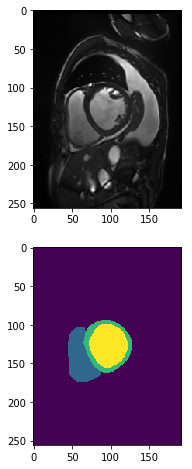

In [6]:
visualize(image, mask)

# Strong augmentation

(256, 192) (256, 192)
(256, 192) (256, 192)
255.0 252.2999
49.43449 50.879436


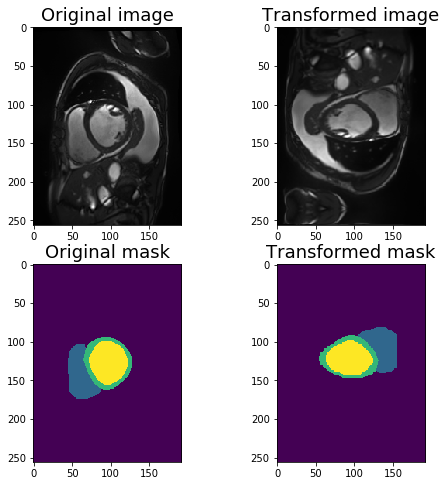

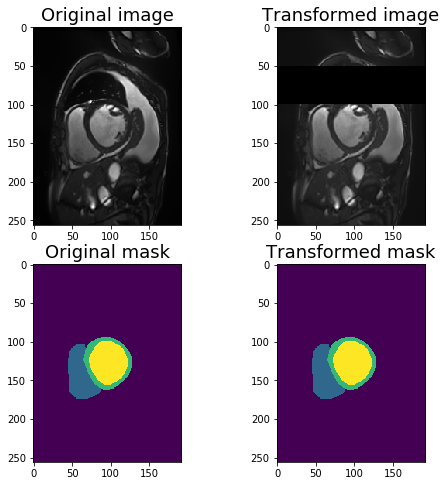

In [25]:
from albumentations.core.composition import ReplayCompose
from albumentations.core.serialization import to_dict, save
from albumentations import Normalize, RandomBrightness, GaussNoise, ToFloat, RandomSnow, ShiftScaleRotate, PadIfNeeded


# apply compose to multiple slices
def strong_aug(p=1):
    return Compose([
        RandomRotate90(p=0.2),
        Flip(0.1),
        Transpose(p=0.1),
        ShiftScaleRotate(rotate_limit=0,p=0.5,border_mode=cv2.BORDER_REFLECT_101),
        GridDistortion(p=0.8, border_mode=cv2.BORDER_REFLECT_101),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1),
        #CenterCrop(height=target_dim[0], width=target_dim[1], p=1),
        # ToFloat(max_value=100,p=1),
        # HueSaturationValue(p=1)
        # RandomBrightnessContrast(brightness_limit=(0,image.max()),contrast_limit=(0.6,0.99),always_apply=True)
        # RandomBrightness(limit=0.1,p=1),
        # GaussNoise(mean=image.mean(),p=1),
    ], p=p,
        additional_targets={})

aug = strong_aug()

image1 = image.copy()
image1[50:100] = 5

data = {"image": image, "mask": mask, 'image1':image1, 'mask1': mask}
augmented = aug(**data)
image_padded = augmented['image']
mask_padded = augmented['mask']
print(image_padded.shape, mask_padded.shape)
visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

image_padded1 = augmented['image1']
mask_padded1 = augmented['mask1']
print(image_padded1.shape, mask_padded1.shape)
visualize(image_padded1, mask_padded1, original_image=image, original_mask=mask)

print(image.max(), image_padded.max())
print(image.mean(), image_padded.mean())
#aug._to_dict()

# Normalize with albumentation
https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Normalize
Divide pixel values by 255 = 2**8 - 1, subtract mean per channel and divide by std per channel.
Parameters:	

    mean (float, list of float) – mean values
    std (float, list of float) – std values
    max_pixel_value (float) – maximum possible pixel value


(256, 192) (256, 192)
52.19047 -1.3374805
38.868454 0.0039215707


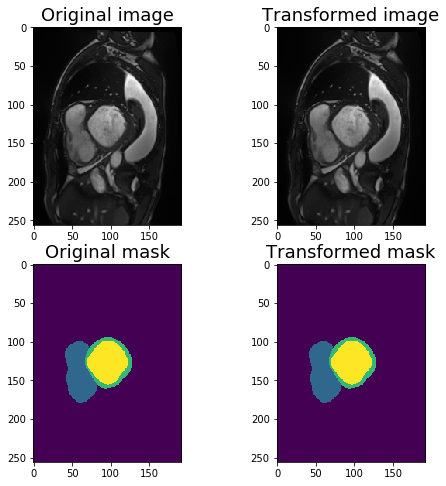

In [41]:

aug = Normalize(p=1, mean=image.mean(), std=image.std())

augmented = aug(image=image, mask=mask)

image_norm = augmented['image']
mask_norm = augmented['mask']

print(image_norm.shape, mask_norm.shape)
print(image.mean(), image_norm.mean())
print(image.std(), image_norm.std())
visualize(image_norm, mask_norm, original_image=image, original_mask=mask)

 # Padding

UNet type architecture require input image size be divisible by $2^N$, where $N$ is th enumber of the maxpooling layers. In the vanilla UNet $N=5$  $\Longrightarrow$ we need to pad input images to the closest divisible by $2^5 = 32$ number which is 128. This operation may be performed using [**PadIfNeeded**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.PadIfNeeded) transformation. Which pads both image and mask on all four sides. Padding type (zero, constant, reflection) may be specified. Default padding is reflection padding.

(256, 224) (256, 224)


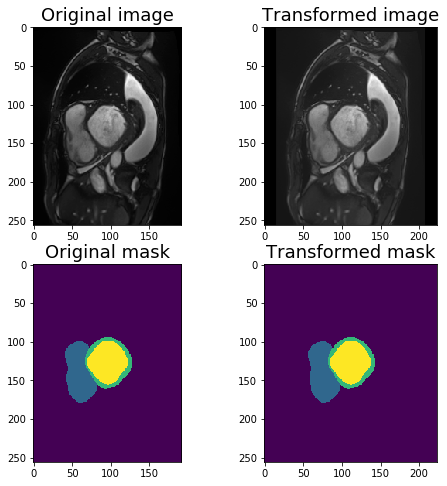

In [8]:

aug = PadIfNeeded(p=1, min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, value=0)

augmented = aug(image=image, mask=mask)

image_padded = augmented['image']
mask_padded = augmented['mask']

print(image_padded.shape, mask_padded.shape)

visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

# CenterCrop and Crop

To get to the original image and mask we may use [**CenterCrop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CenterCrop) or [**Crop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Crop) transformations.

(256, 192) (256, 192)


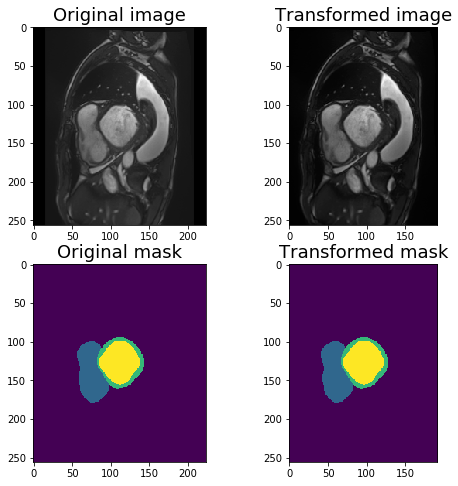

In [9]:
aug = CenterCrop(p=1, height=original_height, width=original_width)

augmented = aug(image=image_padded, mask=mask_padded)

image_center_cropped = augmented['image']
mask_center_cropped = augmented['mask']

print(image_center_cropped.shape, mask_center_cropped.shape)

assert (image - image_center_cropped).sum() == 0
assert (mask - mask_center_cropped).sum() == 0

visualize(image_center_cropped, mask_center_cropped, original_image=image_padded, original_mask=mask_padded)

# Shift and rotate

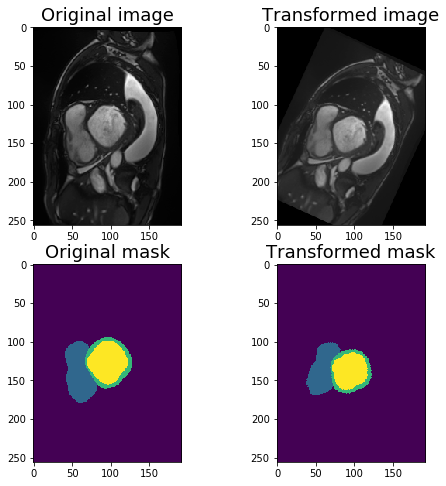

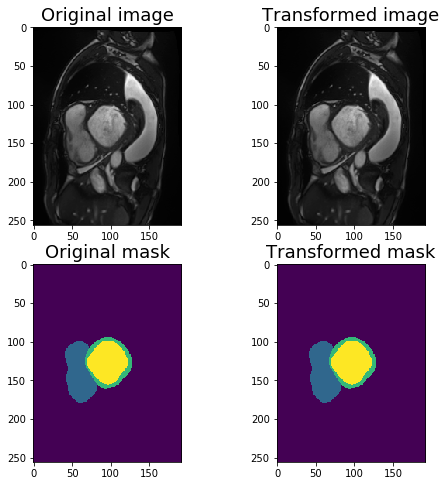

In [10]:
from albumentations import ShiftScaleRotate
aug = ShiftScaleRotate(shift_limit=0.0625,scale_limit=0.1,rotate_limit=90,interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0,mask_value=0)

params = aug.get_params()
image_grid = aug.apply(image, interpolation=cv2.INTER_LINEAR, **params)
mask_grid = aug.apply(mask, interpolation=cv2.INTER_NEAREST, **params)
visualize(image_grid, mask_grid, original_image=image, original_mask=mask)
params
augmented = aug(image=image, mask=mask)
visualize(augmented['image'], augmented['mask'], image, mask)

# Non destructive transformations. [Dehidral group D4](https://en.wikipedia.org/wiki/Dihedral_group)

For images for which there is no clear notion of top like this one, satellite and aerial imagery or medical imagery it is typically a good idea to add transformations that do not add or loose the information.

There are eight distinct ways to represent the same square on the plane.

![D4](https://habrastorage.org/webt/ln/nw/nc/lnnwncjfjsn8zpfo6igvqq-rjky.png)

Combinations of the transformations [HorizontalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.HorizontalFlip), [VerticalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.VerticalFlip), [Transpose](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Transpose), [RandomRotate90](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomRotate90) will be able to get the original image to all eight states.

 ## HorizontalFlip

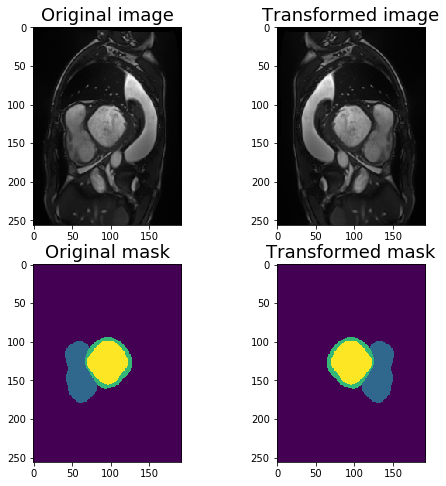

In [11]:
aug = HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

## VerticalFlip

{}

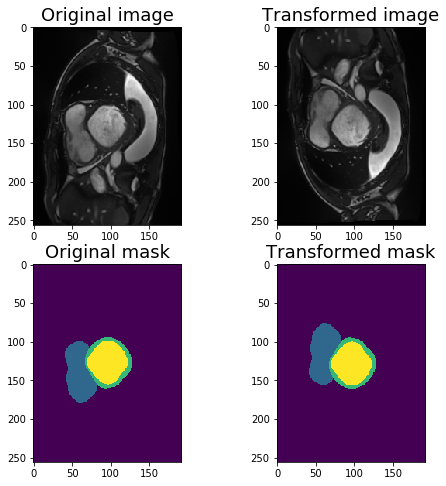

In [12]:
aug = VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)
aug.get_params()

## RandomRotate90 (Randomly rotates by 0, 90, 180, 270 degrees)

{'factor': 1}

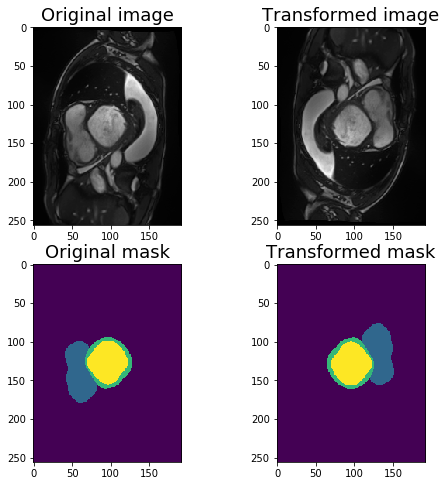

In [13]:
aug = RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)
aug.get_params()

 ## Transpose (switch X and Y axis) 

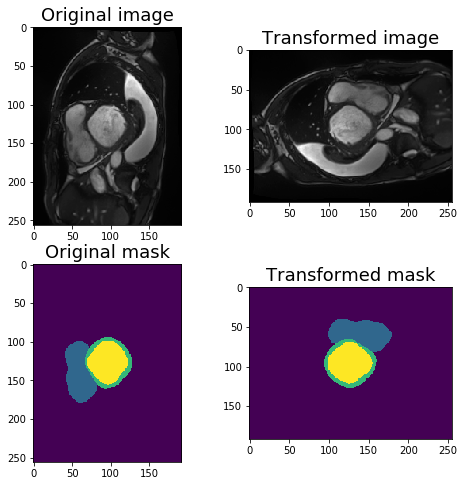

In [14]:
aug = Transpose(p=1)

augmented = aug(image=image, mask=mask)

image_transposed = augmented['image']
mask_transposed = augmented['mask']

visualize(image_transposed, mask_transposed, original_image=image, original_mask=mask)

# Non-rigid transformations: ElasticTransform, GridDistortion, OpticalDistortion

In medical imaging problems non rigind transformations help to augment the data. It is unclear if they will help in this problem, but let's look at them. We will consider [ElasticTransform](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ElasticTransform), [GridDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.GridDistortion), [OpticalDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.OpticalDistortion).

## ElasticTransform

In [4]:
# sigma define how strong we transform the original image/mask
aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.09, alpha_affine=120 * 0.08,border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0)

augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)
aug.get_params()

NameError: name 'cv2' is not defined

In [19]:
%%timeit
aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
augmented = aug(image=image, mask=mask)

9.35 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## GridDistortion

In [58]:
#%%timeit
aug = GridDistortion(p=1)

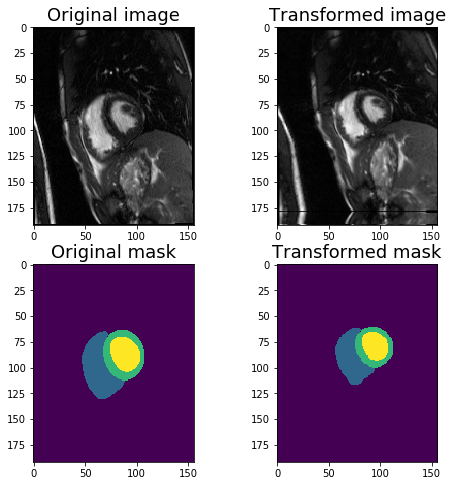

In [59]:
augmented = aug(image=image, mask=mask)

image_grid = augmented['image']
mask_grid = augmented['mask']

visualize(image_grid, mask_grid, original_image=image, original_mask=mask)
plt.savefig('reports/grid_distortion_example.pdf')

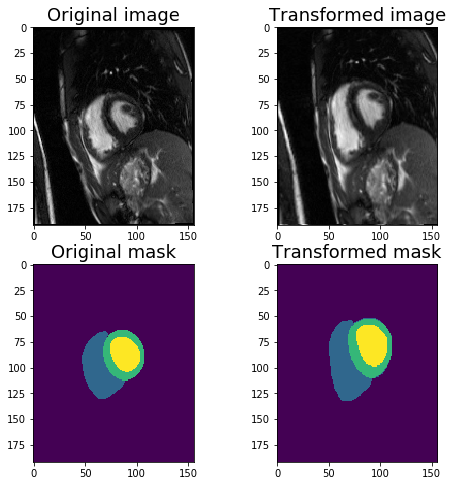

In [36]:
# apply transofrmation to multiple images

aug = GridDistortion(p=1)
steps = aug.get_params()
image_grid = aug.apply(image, steps['stepsx'], steps['stepsy'])
mask_grid = aug.apply(mask, steps['stepsx'], steps['stepsy'])
visualize(image_grid, mask_grid, original_image=image, original_mask=mask)

In [37]:
%%timeit
test = np.dstack([image, image, image]).shape

38.3 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
%%timeit
test = np.stack([image, image, image], axis=-1).shape

39.5 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [39]:
%%timeit
aug = GridDistortion(p=1)
augmented = aug(image=image, mask=mask)

628 µs ± 4.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## OpticalDistortion

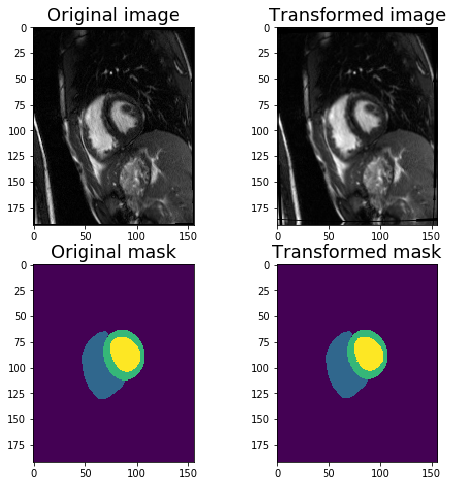

In [46]:
aug = OpticalDistortion(p=1, distort_limit=0.1, shift_limit=0.5)

augmented = aug(image=image, mask=mask)

image_optical = augmented['image']
mask_optical = augmented['mask']

visualize(image_optical, mask_optical, original_image=image, original_mask=mask)

# RandomSizedCrop

One may combine [RandomCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomCrop) and [RandomScale](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomScale) but there is a transformation [RandomSizedCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomSizedCrop) that allows to combine them into one transformation.

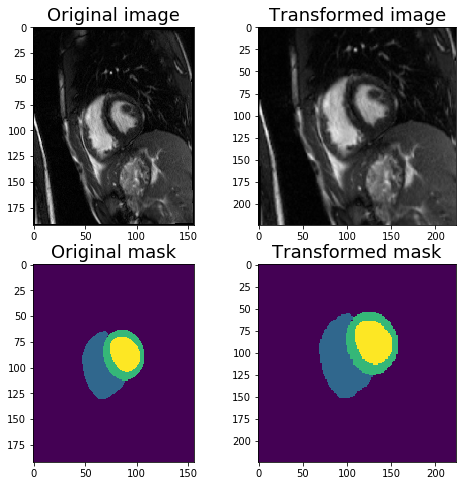

In [52]:
aug = RandomSizedCrop(p=1, min_max_height=(128, min(image.shape[0], image.shape[1])), height=224, width=224)

augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize(image_scaled, mask_scaled, original_image=image, original_mask=mask)

# Let's try to combine different transformations

Light non destructive augmentations.

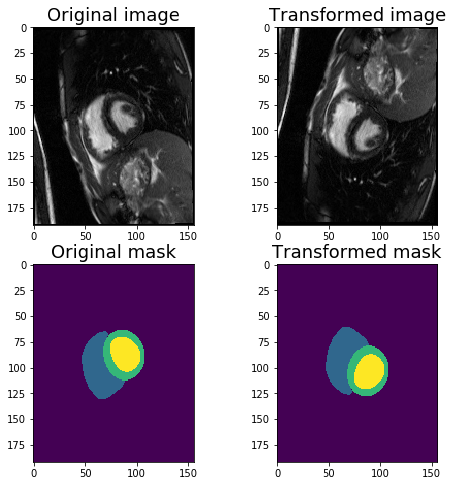

In [54]:
aug = Compose([VerticalFlip(p=0.5),              
              RandomRotate90(p=0.5)])

augmented = aug(image=image, mask=mask)

image_light = augmented['image']
mask_light = augmented['mask']

visualize(image_light, mask_light, original_image=image, original_mask=mask)

# Let's add non rigid transformations and RandomSizedCrop

## Medium augmentations

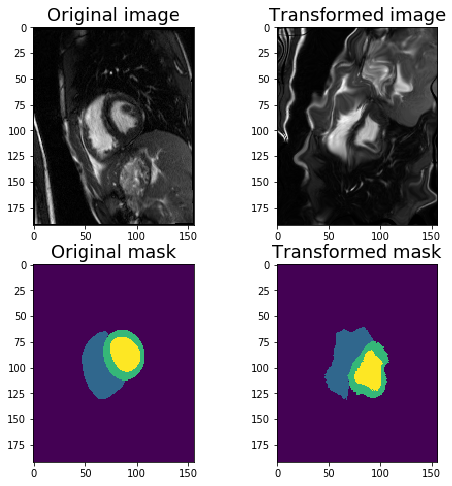

In [55]:
aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
          PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=1, shift_limit=0.5)                  
        ], p=0.8)])

augmented = aug(image=image, mask=mask)

image_medium = augmented['image']
mask_medium = augmented['mask']

visualize(image_medium, mask_medium, original_image=image, original_mask=mask)

# Let's add non-spatial stransformations.

Many non spatial transformations like [CLAHE](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CLAHE), [RandomBrightness](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomBrightness), [RandomContrast](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomContrast), [RandomGamma](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomGamma) can be also added. They will be applied only to the image and not the mask.

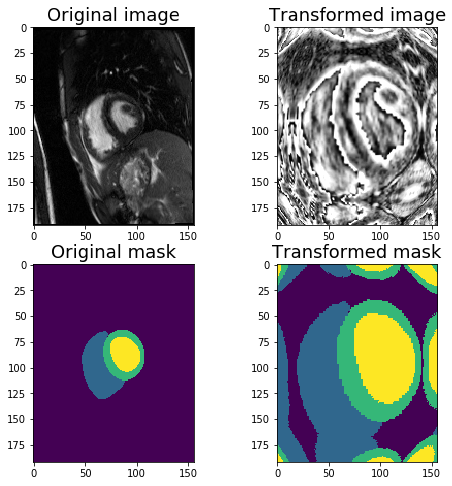

In [56]:
aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
          PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])

augmented = aug(image=image.astype(np.uint8), mask=mask.astype(np.uint8))

image_heavy = augmented['image']
mask_heavy = augmented['mask']

visualize(image_heavy, mask_heavy, original_image=image, original_mask=mask)